In [2]:
# We are using black as a code formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import requests
import json
import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

<IPython.core.display.Javascript object>

## Vamos a descargar las siguientes características:
1. Current health expenditure per capita (current US$) SH.XPD.CHEX.PC.CD
2. Hospital beds (per 1,000 people) SH.MED.BEDS.ZS
3. Mortality rate, infant (per 1,000 live births) SP.DYN.IMRT.IN
4. People using at least basic drinking water services (% of population) SH.H2O.BASW.ZS
5. People using at least basic sanitation services (% of population) SH.STA.BASS.ZS
6. Suicide mortality rate (per 100,000 population)(SH.STA.SUIC.P5)
7. Urban population (% of total population)(SP.URB.TOTL.IN.ZS)
8. Unemployment, total (% of total labor force)(SL.UEM.TOTL.ZS)
9. CO2 emissions (metric tons per capita)(EN.ATM.CO2E.PC)
10. Forest area (% of land area)(AG.LND.FRST.ZS)
11. Political Stability and Absence of Violence/Terrorism: Estimate(PV.EST)
12. Life expentancy at brith SP.DYN.LE00.IN
13. GNI per capita, Atlas method (current US$)(NY.GNP.PCAP.CD)


creamos la lista con los codigos de los indicadores que vamos a descargar

In [21]:
ind_list = ['SH.XPD.CHEX.PC.CD', 'SH.MED.BEDS.ZS', 'SP.DYN.IMRT.IN', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS', 
            'SH.STA.SUIC.P5', 'SP.URB.TOTL.IN.ZS', 'SL.UEM.TOTL.ZS',  'EN.ATM.CO2E.PC', 'AG.LND.FRST.ZS',
            'PV.EST', 'SP.DYN.LE00.IN', 'NY.GNP.PCAP.CD']

<IPython.core.display.Javascript object>

Para ello utilizaremos una funcion 

In [20]:
def extraer (api_url,lista, indicador,tiempo):
    #creamos el argumento paises
    lista3 = lista.copy()
    b = lista3[0]
    lista3.pop(0)
    for a in lista3:
        b = b+';'+a #la API devuelve los datos de varios paises pasando el argumento: AVW;AND;ETH...
    #lista3 = ";".join(lista3) otra forma
    path = f'/country/{b}/indicator/{indicador}'
    url = api_url + path
    args = {"format":"json", "prefix":"Getdata","date":tiempo,"per_page":9000}
    s = requests.get(url, params=args)
    salida = pd.json_normalize(s.json()[1])
    return(salida[['countryiso3code','date','value']])

<IPython.core.display.Javascript object>

Ahora descargamos los datos y generamos los archivos parquet

In [ ]:
url = 'http://api.worldbank.org/v2'
tiempo = '1990:2020'
lista_ids = ['all']
for a in ind_list:
    indicador = a
    df = extraer(api_url=url,lista=lista_ids,indicador=indicador,tiempo=tiempo)
    df.to_parquet(f'/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_{a}.parquet', engine='pyarrow')


Esto lo hice porque no habia descargado la esperanza de vida en un principio para no borrar los parquet que ya
tenia

In [29]:
url = 'http://api.worldbank.org/v2'
tiempo = '1990:2020'
lista_ids = ['all']
indicador = 'SP.DYN.LE00.IN'
df = extraer(api_url=url,lista=lista_ids,indicador=indicador,tiempo=tiempo)
df

,countryiso3code,date,value
0,AFE,2020,64.325702
1,AFE,2019,64.005213
2,AFE,2018,63.648988
3,AFE,2017,63.246264
4,AFE,2016,62.787681
...,...,...,...
8241,ZWE,1994,52.044000
8242,ZWE,1993,53.653000
8243,ZWE,1992,55.243000
8244,ZWE,1991,56.749000


<IPython.core.display.Javascript object>

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4708 entries, 0 to 4707
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   countryiso3code  4708 non-null   object 
 1   date             4708 non-null   object 
 2   value            4540 non-null   float64
dtypes: float64(1), object(2)
memory usage: 110.5+ KB


<IPython.core.display.Javascript object>

Aqui estoy creando el parquet con el dataset de esperanza de vida ya que no lo hice al principio. Ya esta corregido

In [30]:
df.to_parquet(f'/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SP.DYN.LE00.IN.parquet', engine='pyarrow')

<IPython.core.display.Javascript object>

Ya con los datos en el Data Lake procedemos a realizar el EDA

Primero descargamos los parquet para crear el dataframe con todos los datos. Aqui vamos a unir todos los datos para luego eliminar los nulos.. de esta manera haremos el analisis solo sobre los paises que contienen todos los indicadores. En este paso vamos a renombrar la columna 'value' con el nombre del indicador

In [5]:
df = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SP.DYN.LE00.IN.parquet')
df.rename(columns={'value': 'esperanza_vida_nacer'}, inplace=True)
df['porcentaje_de_bosque'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_AG.LND.FRST.ZS.parquet')['value']
df['emisiones_co2'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_EN.ATM.CO2E.PC.parquet')['value']
df['inversion_salud_percapita'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SH.XPD.CHEX.PC.CD.parquet')['value']
df['camas_hospitales_c/1000personas'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SH.MED.BEDS.ZS.parquet')['value']
df['mortalidad_infantil_c/1000nacimientos'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SP.DYN.IMRT.IN.parquet')['value']
df['porcentaje_personas_acceso_agua_potable'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SH.H2O.BASW.ZS.parquet')['value']
df['porcentaje_personas_acceso_servicios_sanitarios'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SH.STA.BASS.ZS.parquet')['value']
df['tasa_mortalidad_suicidio_c/100.000'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SH.STA.SUIC.P5.parquet')['value']
df['tasa_desempleo'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SL.UEM.TOTL.ZS.parquet')['value']
df['tasa_poblacion_urbana'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_SP.URB.TOTL.IN.ZS.parquet')['value']
df['ingreso_nacional_bruto_percapita'] = pd.read_parquet('/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_NY.GNP.PCAP.CD.parquet')['value']


<IPython.core.display.Javascript object>

In [109]:
df

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita
0,AFE,2020,64.325702,30.174186,NaN,NaN,NaN,42.447198,59.511910,30.931064,NaN,7.563187,36.783306,1397.543390
1,AFE,2019,64.005213,30.391558,0.913618,91.970113,NaN,43.591252,58.782401,30.742610,8.036293,6.914353,36.291322,1506.731921
2,AFE,2018,63.648988,30.611444,0.917507,96.289480,NaN,44.795221,57.860301,30.384759,8.128884,6.731163,35.807770,1464.995375
3,AFE,2017,63.246264,30.824248,0.937926,102.410661,NaN,46.108140,56.921012,30.114592,8.244062,6.714955,35.332373,1459.517554
4,AFE,2016,62.787681,31.039613,0.948410,94.739159,NaN,47.527244,55.963351,29.618405,8.324659,6.610205,34.865101,1475.979716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241,ZWE,1994,52.044000,48.190255,1.417186,NaN,NaN,55.000000,NaN,NaN,NaN,4.960000,31.335000,630.000000
8242,ZWE,1993,53.653000,48.309345,1.539741,NaN,NaN,53.700000,NaN,NaN,NaN,4.974000,30.940000,640.000000
8243,ZWE,1992,55.243000,48.428435,1.694416,NaN,NaN,52.400000,NaN,NaN,NaN,4.993000,30.499000,700.000000
8244,ZWE,1991,56.749000,48.547525,1.713321,NaN,NaN,51.200000,NaN,NaN,NaN,4.941000,29.738000,850.000000


<IPython.core.display.Javascript object>

In [6]:
def grupo (b):
    a = b['ingreso_nacional_bruto_percapita']
    try:
        float(a)
    except:
        return ''
    if a < 1086:
        return 'low_income'
    elif a < 4256:
        return 'lower_middle_income'
    elif a < 13206:
        return 'upper_middle_income'
    else:
        return 'high_income'

<IPython.core.display.Javascript object>

Aplicamos la funcion grupo para crear la columna con las clasificaciones

In [7]:
df['nivel_ingreso'] = df.apply(grupo,axis=1)

<IPython.core.display.Javascript object>

In [116]:
df

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
0,AFE,2020,64.325702,30.174186,NaN,NaN,NaN,42.447198,59.511910,30.931064,NaN,7.563187,36.783306,1397.543390,lower_middle_income
1,AFE,2019,64.005213,30.391558,0.913618,91.970113,NaN,43.591252,58.782401,30.742610,8.036293,6.914353,36.291322,1506.731921,lower_middle_income
2,AFE,2018,63.648988,30.611444,0.917507,96.289480,NaN,44.795221,57.860301,30.384759,8.128884,6.731163,35.807770,1464.995375,lower_middle_income
3,AFE,2017,63.246264,30.824248,0.937926,102.410661,NaN,46.108140,56.921012,30.114592,8.244062,6.714955,35.332373,1459.517554,lower_middle_income
4,AFE,2016,62.787681,31.039613,0.948410,94.739159,NaN,47.527244,55.963351,29.618405,8.324659,6.610205,34.865101,1475.979716,lower_middle_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241,ZWE,1994,52.044000,48.190255,1.417186,NaN,NaN,55.000000,NaN,NaN,NaN,4.960000,31.335000,630.000000,low_income
8242,ZWE,1993,53.653000,48.309345,1.539741,NaN,NaN,53.700000,NaN,NaN,NaN,4.974000,30.940000,640.000000,low_income
8243,ZWE,1992,55.243000,48.428435,1.694416,NaN,NaN,52.400000,NaN,NaN,NaN,4.993000,30.499000,700.000000,low_income
8244,ZWE,1991,56.749000,48.547525,1.713321,NaN,NaN,51.200000,NaN,NaN,NaN,4.941000,29.738000,850.000000,low_income


<IPython.core.display.Javascript object>

vamos a guardar en parquet la tabla preliminar

In [117]:
df.to_parquet(f'/home/ravi/Documents/Henry/PG/life-expectancy/datasets/df_TWB_tabla.preliminar.parquet', engine='pyarrow')

<IPython.core.display.Javascript object>

Ahora si comenzamos el eda

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   countryiso3code                                  8246 non-null   object 
 1   date                                             8246 non-null   object 
 2   esperanza_vida_nacer                             7669 non-null   float64
 3   porcentaje_de_bosque                             7897 non-null   float64
 4   emisiones_co2                                    7144 non-null   float64
 5   inversion_salud_percapita                        4694 non-null   float64
 6   camas_hospitales_c/1000personas                  3683 non-null   float64
 7   mortalidad_infantil_c/1000nacimientos            7471 non-null   float64
 8   porcentaje_personas_acceso_agua_potable          5419 non-null   float64
 9   porcentaje_personas_acceso_ser

<IPython.core.display.Javascript object>

eliminamos los los nulos

In [8]:
df2 = df
df2.dropna(inplace=True)
df2

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
14,AFE,2006,54.791707,33.297802,0.999696,77.243024,0.911871,67.582229,46.095149,25.252879,9.702909,6.989477,30.646243,1156.230162,lower_middle_income
65,ARB,2017,71.622670,2.863943,4.511545,373.501827,1.380434,27.292722,88.094412,82.784114,4.179462,10.896379,58.642322,6148.395043,upper_middle_income
66,ARB,2016,71.436547,2.883323,4.550515,351.301810,2.073525,28.083766,87.684054,82.344425,4.258030,10.761115,58.345627,6563.464625,upper_middle_income
67,ARB,2015,71.249571,2.900938,4.590846,349.118729,1.485156,28.695965,87.145426,81.765652,4.333516,10.965901,58.031466,6995.510522,upper_middle_income
68,ARB,2014,71.064269,2.919452,4.568055,365.397264,2.274647,29.355394,86.585408,81.191821,4.441166,10.872227,57.692325,7475.881945,upper_middle_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8173,YEM,2000,60.683000,1.039832,0.863343,25.827745,0.590000,68.800000,40.879071,45.238717,6.100000,11.558000,26.267000,430.000000,low_income
8194,ZMB,2010,55.655000,62.814942,0.195502,55.392830,2.000000,51.200000,57.100215,27.309684,10.100000,13.190000,39.355000,1340.000000,lower_middle_income
8196,ZMB,2008,52.606000,62.911258,0.170448,55.939053,1.900000,54.500000,55.356759,26.301548,9.700000,7.930000,38.371000,1180.000000,lower_middle_income
8200,ZMB,2004,47.354000,63.103889,0.182674,37.970741,2.000000,67.100000,51.772890,24.207510,12.200000,15.298000,36.430000,460.000000,low_income


<IPython.core.display.Javascript object>

ahora vamos a extraer un subset de datos con los paises de bajos ingresos económicos

In [135]:
mask1 = (df2['nivel_ingreso']=='low_income')
df_low = df2[mask1]
df_low

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
235,EAP,2002,70.748365,29.053586,2.526284,43.534236,1.643425,29.561735,81.085423,59.119972,9.957707,4.147311,38.702776,1061.771524,low_income
236,EAP,2001,70.442285,28.933934,2.378906,39.020439,1.658500,31.387162,80.182264,57.017141,10.457803,3.833542,37.593405,981.015282,low_income
237,EAP,2000,70.136177,28.815315,2.277695,37.885522,1.707603,33.168466,79.705676,56.089377,11.520155,3.405417,36.564471,909.917407,low_income
266,TEA,2002,70.797231,28.869431,2.519654,43.535646,1.491941,29.498345,80.852128,58.914377,9.963557,4.165176,38.434823,1074.012520,low_income
267,TEA,2001,70.497944,28.747540,2.368282,39.022173,1.658500,31.279932,79.937302,57.016936,10.470043,3.846298,37.312288,992.323875,low_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8171,YEM,2002,61.781000,1.039832,0.872385,28.017159,0.590000,62.800000,41.343131,45.862323,5.900000,11.840000,27.315000,520.000000,low_income
8172,YEM,2001,61.216000,1.039832,0.896845,27.195436,0.590000,65.800000,41.109331,45.548141,6.100000,11.714000,26.787000,480.000000,low_income
8173,YEM,2000,60.683000,1.039832,0.863343,25.827745,0.590000,68.800000,40.879071,45.238717,6.100000,11.558000,26.267000,430.000000,low_income
8200,ZMB,2004,47.354000,63.103889,0.182674,37.970741,2.000000,67.100000,51.772890,24.207510,12.200000,15.298000,36.430000,460.000000,low_income


<IPython.core.display.Javascript object>

In [126]:
df_low.isnull().sum()

countryiso3code                                    0
date                                               0
esperanza_vida_nacer                               0
porcentaje_de_bosque                               0
emisiones_co2                                      0
inversion_salud_percapita                          0
camas_hospitales_c/1000personas                    0
mortalidad_infantil_c/1000nacimientos              0
porcentaje_personas_acceso_agua_potable            0
porcentaje_personas_acceso_servicios_sanitarios    0
tasa_mortalidad_suicidio_c/100.000                 0
tasa_desempleo                                     0
tasa_poblacion_urbana                              0
ingreso_nacional_bruto_percapita                   0
nivel_ingreso                                      0
dtype: int64

<IPython.core.display.Javascript object>

In [127]:
df_low.describe()

,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,63.149045,22.759765,1.123816,35.676914,2.164675,52.526304,69.147509,46.864880,9.258834,6.288352,33.413470,633.286410
std,6.091324,20.795572,1.625911,22.352142,2.324494,19.943844,18.474508,28.241260,5.900885,4.292078,12.402845,247.400891
min,45.158000,0.881787,0.023660,4.335375,0.100000,13.400000,24.525267,4.071684,1.300000,0.390000,9.617000,130.000000
25%,59.590500,6.755239,0.201472,20.494795,0.600000,37.250000,51.781667,22.598565,5.300000,2.721000,26.502000,452.332089
50%,63.951000,16.028963,0.690167,31.065983,0.900000,53.400000,76.002724,41.060966,7.800000,5.354000,30.842005,610.000000
75%,67.734061,32.357359,1.096655,43.599662,3.200000,65.400000,84.097059,67.127673,12.500000,9.834000,38.001500,850.000000
max,74.625000,94.283866,9.955427,208.867523,8.890000,120.900000,98.180680,97.406766,39.100000,16.799999,68.658000,1080.000000


<IPython.core.display.Javascript object>

aqui vemos que la media de la esperanza de vida al nacer para los paises de bajos ingresos es de 63.15 años

veamos la correlacion entre las variables numericas

In [14]:
import seaborn as sns

<IPython.core.display.Javascript object>

<AxesSubplot:>

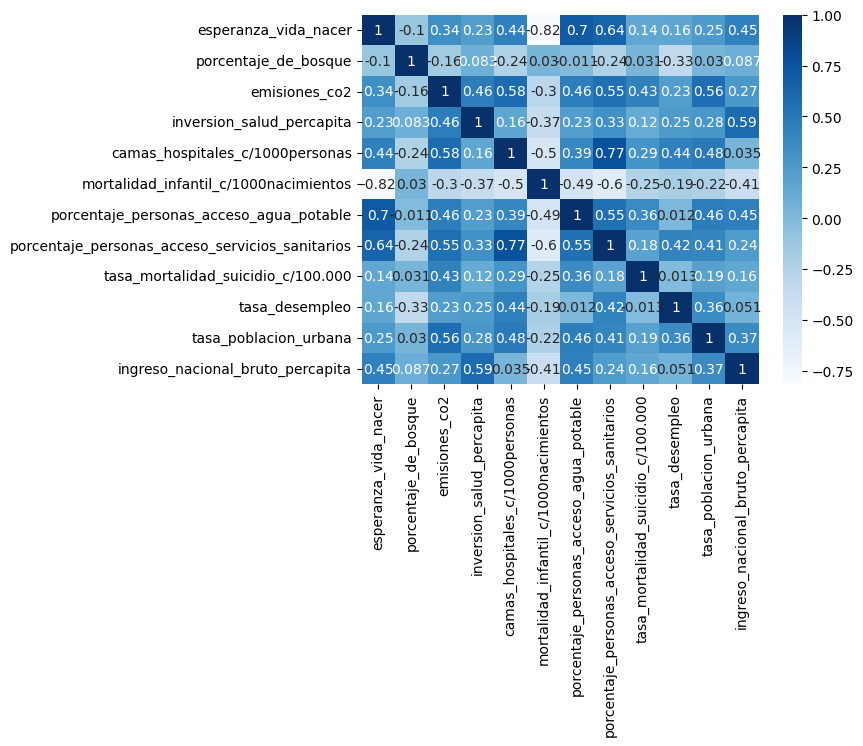

<IPython.core.display.Javascript object>

In [131]:
corr = df_low.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

aqui vemos que hay tres variables con alta correlacion entre la variable objetivo y: mortalidad_infantil, porcentaje_personas_acceso_agua_potable, y a su vez alta correlacion entre procentaje_personas_acceso_servicios_sanitarios y camas_hospitales. Procedemos a descartarlas

<AxesSubplot:>

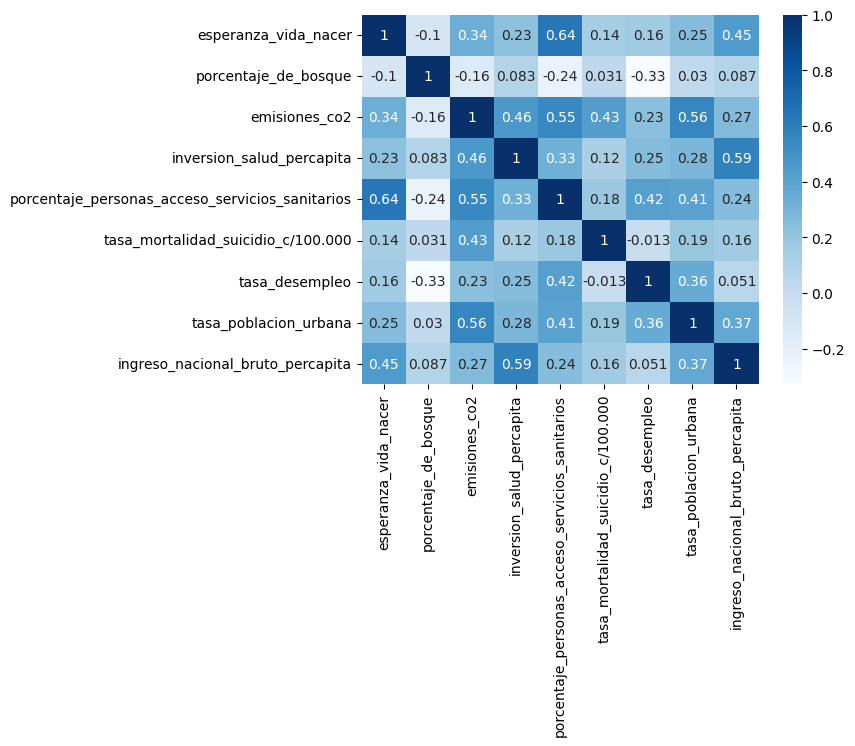

<IPython.core.display.Javascript object>

In [133]:
corr = df_low.drop(['mortalidad_infantil_c/1000nacimientos', 'porcentaje_personas_acceso_agua_potable',
                    'camas_hospitales_c/1000personas'], axis=1).corr()
sns.heatmap(corr, cmap="Blues", annot=True)

ahora probemos el modelo para los paises del grupo lower_middle_income

In [134]:
mask1 = (df2['nivel_ingreso']=='lower_middle_income')
df_lm = df2[mask1]
df_lm

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
14,AFE,2006,54.791707,33.297802,0.999696,77.243024,0.911871,67.582229,46.095149,25.252879,9.702909,6.989477,30.646243,1156.230162,lower_middle_income
77,ARB,2005,69.164683,3.479055,3.773437,136.974559,1.622474,37.823952,81.164668,75.572248,4.444661,11.195937,54.470306,3790.596122,lower_middle_income
78,ARB,2004,68.886188,3.493470,3.613897,123.286289,1.606222,39.032681,80.554943,74.959347,4.447686,11.352673,54.105582,3327.897101,lower_middle_income
79,ARB,2003,68.610506,3.507880,3.506168,112.541927,1.571151,40.274588,80.113288,74.547420,4.496886,12.390521,53.801167,2869.172536,lower_middle_income
80,ARB,2002,68.340246,3.522247,3.477800,115.760808,1.576436,41.501087,79.683358,74.163207,4.546875,12.465001,53.515626,2688.919198,lower_middle_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,YEM,2012,65.920000,1.039832,0.858491,75.143700,0.720000,45.400000,52.671017,50.518999,5.700000,13.167000,32.958000,1260.000000,lower_middle_income
8163,YEM,2010,65.549000,1.039832,1.098258,68.865936,0.720000,45.500000,50.528009,49.754511,5.700000,12.831000,31.776000,1200.000000,lower_middle_income
8164,YEM,2009,65.255000,1.039832,1.180025,66.811066,0.700000,46.400000,49.435323,49.353046,5.900000,12.749000,31.194000,1100.000000,lower_middle_income
8194,ZMB,2010,55.655000,62.814942,0.195502,55.392830,2.000000,51.200000,57.100215,27.309684,10.100000,13.190000,39.355000,1340.000000,lower_middle_income


<IPython.core.display.Javascript object>

In [137]:
df_lm.isnull().sum()

countryiso3code                                    0
date                                               0
esperanza_vida_nacer                               0
porcentaje_de_bosque                               0
emisiones_co2                                      0
inversion_salud_percapita                          0
camas_hospitales_c/1000personas                    0
mortalidad_infantil_c/1000nacimientos              0
porcentaje_personas_acceso_agua_potable            0
porcentaje_personas_acceso_servicios_sanitarios    0
tasa_mortalidad_suicidio_c/100.000                 0
tasa_desempleo                                     0
tasa_poblacion_urbana                              0
ingreso_nacional_bruto_percapita                   0
nivel_ingreso                                      0
dtype: int64

<IPython.core.display.Javascript object>

In [138]:
df_lm.describe()

,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000
mean,69.897098,27.944658,2.751324,148.756798,2.632003,27.592552,87.449703,73.278657,10.483692,8.919673,52.100007,2514.913495
std,4.197479,20.836767,2.156961,80.483809,2.373598,13.610208,9.782034,17.740191,9.389424,6.069956,14.605632,964.304130
min,42.595000,0.045186,0.170448,27.041063,0.100000,5.900000,46.095149,13.551110,1.400000,0.720000,18.196000,1090.000000
25%,68.164571,10.376969,1.257650,83.679145,1.070000,17.700000,84.320268,61.769076,4.447686,4.900000,42.705000,1640.000000
50%,70.451000,28.123248,2.156798,135.405564,1.826471,24.100000,88.845049,75.493128,8.331917,6.989477,51.947000,2390.000000
75%,72.513000,40.171248,3.566817,198.875580,3.010000,36.069905,93.937479,87.837663,12.169038,11.810000,63.535000,3380.000000
max,77.871000,98.338910,12.104715,418.090302,12.610000,100.900000,100.000000,100.000000,53.800000,37.250000,92.828000,4250.000000


<IPython.core.display.Javascript object>

aqui vemos que la esperanza promedio de vida al nacer para los paises de ingresos medio-bajos es de 69.90

<AxesSubplot:>

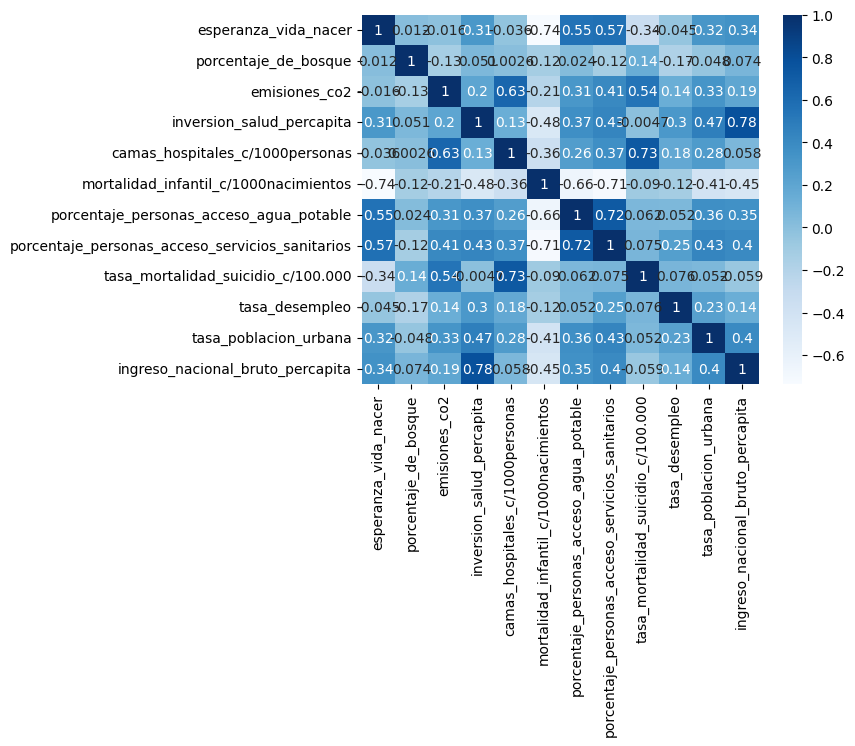

<IPython.core.display.Javascript object>

In [139]:
corr = df_lm.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

Efectivamente la correlacion entre las variables cambia en este grupo de paises. Ahora vemos que la variable mortalidad_infantil tiene alta correlacion con la variable objetivo, la variable inversion_salud_percapita tiene alta correlacion con ingreso_bruto_nacional_percapita, camas_hospitales tiene alta correlacion con tasa_suicidios y que las variables porcentaje_personas_acceso_agua potable y porcentaje_personas_acceso_servicios_sanitarios tienen alta correlacion entre si. Se eliminan las requeridas.

<AxesSubplot:>

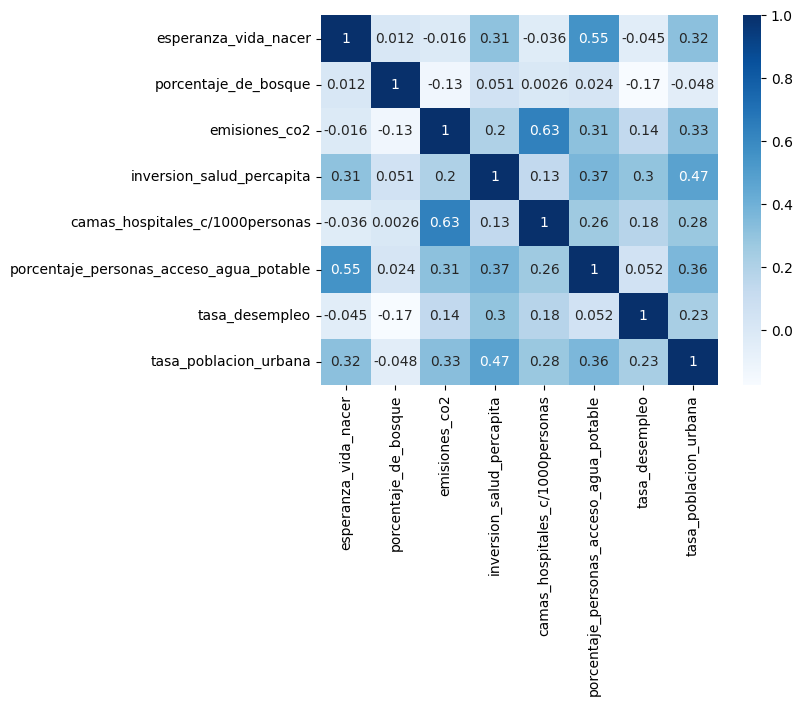

<IPython.core.display.Javascript object>

In [140]:
corr = df_lm.drop(['mortalidad_infantil_c/1000nacimientos', 'ingreso_nacional_bruto_percapita', 
                    'porcentaje_personas_acceso_servicios_sanitarios', 'tasa_mortalidad_suicidio_c/100.000'], axis=1).corr()
sns.heatmap(corr, cmap="Blues", annot=True)

hacemos el eda para la categoría de ingresos medio altos

In [141]:
mask1 = (df2['nivel_ingreso']=='upper_middle_income')
df_um = df2[mask1]
df_um

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
65,ARB,2017,71.622670,2.863943,4.511545,373.501827,1.380434,27.292722,88.094412,82.784114,4.179462,10.896379,58.642322,6148.395043,upper_middle_income
66,ARB,2016,71.436547,2.883323,4.550515,351.301810,2.073525,28.083766,87.684054,82.344425,4.258030,10.761115,58.345627,6563.464625,upper_middle_income
67,ARB,2015,71.249571,2.900938,4.590846,349.118729,1.485156,28.695965,87.145426,81.765652,4.333516,10.965901,58.031466,6995.510522,upper_middle_income
68,ARB,2014,71.064269,2.919452,4.568055,365.397264,2.274647,29.355394,86.585408,81.191821,4.441166,10.872227,57.692325,7475.881945,upper_middle_income
69,ARB,2013,70.882218,2.937937,4.513583,338.870503,1.150741,30.005500,86.025209,80.618798,4.502491,10.735393,57.400734,7436.622615,upper_middle_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7951,URY,2005,75.826000,8.856988,1.631646,440.451996,2.400000,12.500000,97.457301,93.611631,14.800000,12.010000,93.319000,4720.000000,upper_middle_income
8035,VEN,2014,72.762000,53.111955,5.966121,698.915833,0.780000,15.400000,94.748370,94.669603,2.100000,6.864000,88.144000,13080.000000,upper_middle_income
8038,VEN,2011,73.110000,53.671107,5.540041,786.346313,0.930000,14.700000,95.279654,94.124619,3.600000,6.900000,88.108000,11980.000000,upper_middle_income
8040,VEN,2009,73.116000,54.044102,5.443614,886.777222,1.100000,14.600000,95.633844,93.761297,3.200000,6.100000,88.057000,10380.000000,upper_middle_income


<IPython.core.display.Javascript object>

In [142]:
df_um.isnull().sum()

countryiso3code                                    0
date                                               0
esperanza_vida_nacer                               0
porcentaje_de_bosque                               0
emisiones_co2                                      0
inversion_salud_percapita                          0
camas_hospitales_c/1000personas                    0
mortalidad_infantil_c/1000nacimientos              0
porcentaje_personas_acceso_agua_potable            0
porcentaje_personas_acceso_servicios_sanitarios    0
tasa_mortalidad_suicidio_c/100.000                 0
tasa_desempleo                                     0
tasa_poblacion_urbana                              0
ingreso_nacional_bruto_percapita                   0
nivel_ingreso                                      0
dtype: int64

<IPython.core.display.Javascript object>

In [143]:
df_um.describe()

,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000
mean,73.567158,34.700888,5.074911,477.769233,3.580778,15.664466,93.937554,86.937464,10.855480,9.011859,65.140813,7547.864784
std,3.385322,21.324467,3.143992,235.064632,2.290516,9.608781,4.593976,9.230451,8.669574,5.492997,13.637221,2484.473642
min,53.447000,0.009693,0.824126,58.473927,0.780000,2.600000,59.291794,39.876353,0.600000,0.620000,18.450000,4260.000000
25%,72.093167,22.132914,2.772968,303.870568,1.816993,8.300000,91.406339,82.485079,4.900000,5.418445,54.588844,5410.000000
50%,73.983346,34.055994,4.204372,438.363825,2.720000,14.400000,94.702768,87.639240,8.400000,7.450000,65.434370,7070.000000
75%,75.458500,48.838782,6.360635,586.792254,5.070000,19.500000,97.235789,94.249027,13.250000,10.765558,76.314000,9295.000000
max,80.279000,98.154891,23.893712,1531.484253,11.450000,81.700000,100.000003,100.000000,49.800000,33.759998,94.612000,13190.000000


<IPython.core.display.Javascript object>

Una vez mas observamos que al aumentar la categoría de ingresos, aumenta el promedio en la esperanza de vida al nacer. En el caso de los paises de ingreso medio alto el valor del promedio es de 73.57

<AxesSubplot:>

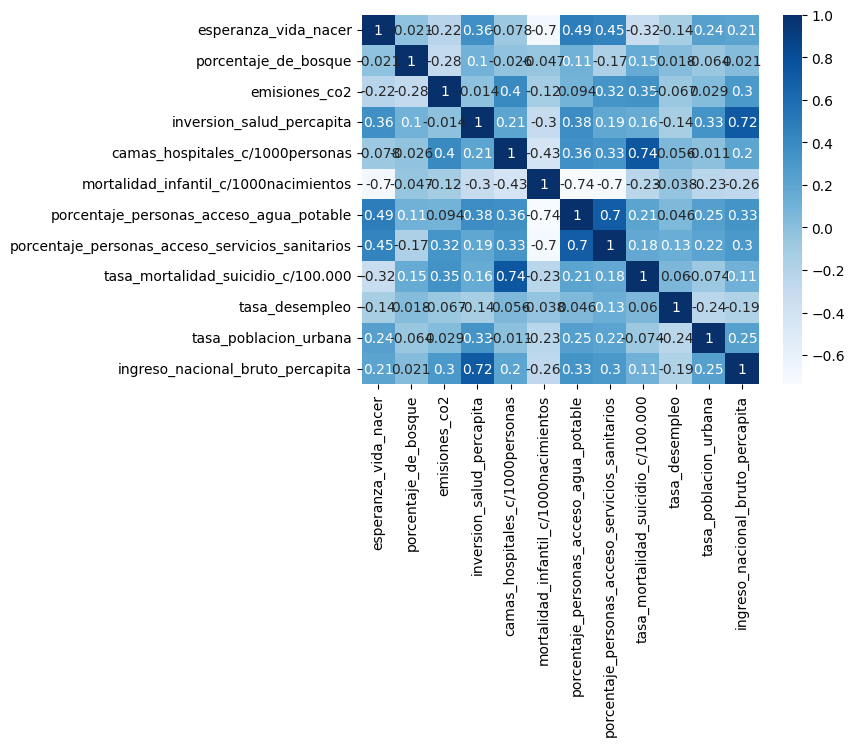

<IPython.core.display.Javascript object>

In [144]:
corr = df_um.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

Ahora vamos con los de altos ingresos

In [9]:
mask1 = (df2['nivel_ingreso']=='high_income')
df_hi = df2[mask1]
df_hi

,countryiso3code,date,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita,nivel_ingreso
126,CEB,2018,76.976823,34.500882,6.568853,1053.877668,6.422667,4.213126,99.739248,95.365419,13.350388,4.316407,62.333667,14665.180535,high_income
129,CEB,2015,76.571878,34.339978,6.235843,812.044395,6.579650,4.835834,99.477168,94.315774,15.408936,7.816836,62.140672,13258.430375,high_income
130,CEB,2014,76.675624,34.208408,6.119356,930.562374,6.582223,5.067670,99.390628,93.869353,16.169605,8.951027,62.113645,13568.337844,high_income
131,CEB,2013,76.355163,34.099423,6.311026,914.354089,6.556355,5.340969,99.289319,93.443048,17.016254,10.046926,62.096814,13428.533383,high_income
281,EMU,2018,82.049581,38.560420,6.437263,4071.212064,4.277151,3.122405,99.902553,99.051150,11.413802,8.170314,76.993086,38870.644791,high_income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,URY,2016,77.498000,11.124443,1.904128,1450.144897,2.480000,7.200000,99.266250,96.903150,21.100000,7.840000,95.144000,15440.000000,high_income
7941,URY,2015,77.369000,10.970175,1.946065,1406.522339,2.430000,7.600000,99.131398,96.613315,18.600000,7.490000,95.045000,15620.000000,high_income
7942,URY,2014,77.244000,10.754542,1.911518,1476.200806,2.420000,8.000000,98.993558,96.322639,17.400000,6.550000,94.945000,15790.000000,high_income
7943,URY,2013,77.124000,10.538910,2.171453,1497.068848,2.490000,8.300000,98.852580,96.031080,15.800000,6.440000,94.843000,15330.000000,high_income


<IPython.core.display.Javascript object>

In [11]:
df_hi.describe()

,esperanza_vida_nacer,porcentaje_de_bosque,emisiones_co2,inversion_salud_percapita,camas_hospitales_c/1000personas,mortalidad_infantil_c/1000nacimientos,porcentaje_personas_acceso_agua_potable,porcentaje_personas_acceso_servicios_sanitarios,tasa_mortalidad_suicidio_c/100.000,tasa_desempleo,tasa_poblacion_urbana,ingreso_nacional_bruto_percapita
count,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000
mean,79.065724,30.583520,10.692664,3136.361687,4.724088,5.148226,99.328510,98.307716,12.708122,6.878944,78.406837,35889.819440
std,2.744670,19.685593,6.557176,2058.535094,2.349261,3.115408,1.480195,2.449590,6.318682,3.793713,12.505146,17131.829220
min,70.072195,0.000000,1.774987,384.208710,0.010000,1.600000,86.783201,87.315157,0.300000,0.140000,31.159000,13230.000000
25%,77.644232,14.651163,6.587408,1386.471863,2.970000,3.200000,99.227428,97.998795,8.200000,4.480000,72.852789,22184.899732
50%,79.504000,32.465327,8.650990,2606.775879,4.380000,4.100000,99.865940,99.138243,12.500000,6.380000,79.990000,34150.000000
75%,81.146341,38.652910,12.007230,4516.142364,5.949587,6.000000,100.000000,99.885815,15.614973,8.435000,85.971500,45425.000000
max,84.210976,73.735645,50.954034,10103.091797,14.690000,22.400000,100.000005,100.000004,40.500000,27.469999,100.000000,104370.000000


<IPython.core.display.Javascript object>

Esperanza de vida promedio para los paises de altos ingresos 79.07

<AxesSubplot:>

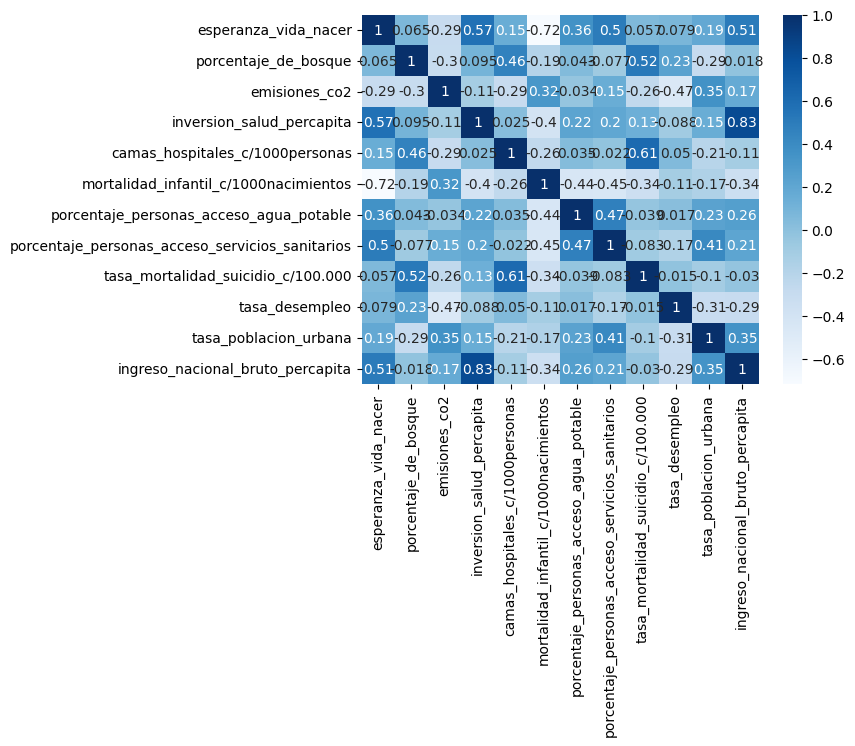

<IPython.core.display.Javascript object>

In [15]:
corr = df_hi.corr()
sns.heatmap(corr, cmap="Blues", annot=True)